# Exercise 1

Train this RNN to solve the sequence classification problem using the given dataset

In [53]:
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

### Define Dataset

In [48]:
class PointSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        with open(data) as f:
            self.data = json.load(f)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = torch.tensor(self.data[idx]["sequence"])
        cls = torch.tensor(self.data[idx]["intersect"]).long()
        return seq, cls

Visualize an instance of the dataset

Training Samples: 8000
Each sample is made by 11 (x,y) datapoints and 1 label


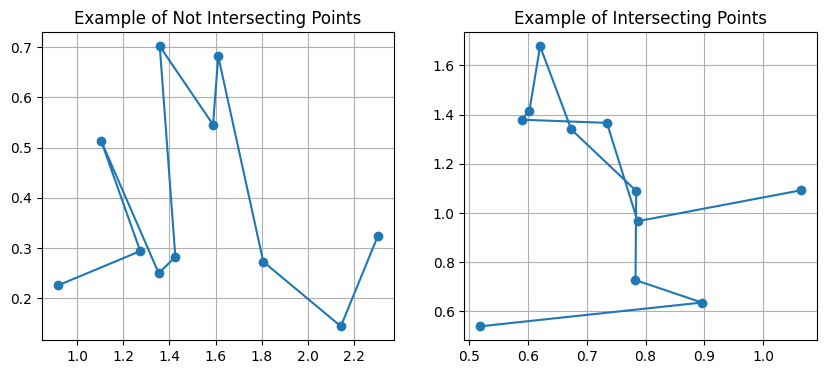

In [49]:
dataset = PointSequenceDataset("train_dataset.json")
print(f"Training Samples: {len(dataset)}")
print(f"Each sample is made by {len(dataset[0][0])} (x,y) datapoints and 1 label")

idx = [0, 6]
fig, axes = plt.subplots(1, len(idx), figsize=(10, 4))

for i1, i2 in enumerate(idx):
    datapoints, label = dataset[i2]
        
    x_coords = datapoints[:, 0]
    y_coords = datapoints[:, 1]
    
    # Plot the line
    axes[i1].plot(x_coords, y_coords, marker='o')  # 'o' for marking each point

    axes[i1].set_title('Example of Intersecting Points' if label else 'Example of Not Intersecting Points')
    axes[i1].grid(True)
plt.show()

### Define Model

In [50]:
class RNNModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.rnn = torch.nn.Sequential(
            torch.nn.Linear(input_size + hidden_size, hidden_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_size, hidden_size),
        )
        self.ff = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        hidden_state = torch.zeros(x.shape[0], self.hidden_size, device=x.device)
        
        for t in range(x.shape[1]):
            input = torch.cat([x[:, t, :], hidden_state], dim=1)
            hidden_state = self.rnn(input)
            
        return self.ff(hidden_state)

In [57]:
train_ds = PointSequenceDataset("train_dataset.json")
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)

model = RNNModel(2, 300, 2)
model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

loss_history = []
acc_history = []

for epoch in range(20):
    bar = tqdm(enumerate(train_dl))
    for i, (serie, cls) in bar:
        
        serie = serie.to(DEVICE)
        cls = cls.to(DEVICE)
        
        out = model(serie)
        loss = loss_fn(out, cls)

        acc = (out.argmax(dim=1) == cls).float().mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        bar.set_description(f"Epoch {epoch} Loss: {loss.item():.4f} Acc: {acc.item():.4f}")
        
        if i % 50 == 0:
            loss_history.append(loss.item())
            acc_history.append(acc.item())

Epoch 0 Loss 0.6867 Acc: 0.6250: : 250it [00:04, 56.84it/s]
Epoch 1 Loss 0.6909 Acc: 0.5312: : 250it [00:04, 55.34it/s]
Epoch 2 Loss 0.6207 Acc: 0.6562: : 250it [00:04, 54.51it/s]
Epoch 3 Loss 0.6785 Acc: 0.5625: : 250it [00:04, 54.49it/s]
Epoch 4 Loss 0.6246 Acc: 0.6250: : 250it [00:04, 54.88it/s]
Epoch 5 Loss 0.6770 Acc: 0.5938: : 250it [00:04, 56.85it/s]
Epoch 6 Loss 0.6009 Acc: 0.7188: : 250it [00:04, 50.76it/s]
Epoch 7 Loss 0.6263 Acc: 0.7500: : 250it [00:05, 47.11it/s]
Epoch 8 Loss 0.6443 Acc: 0.5625: : 250it [00:04, 56.91it/s]
Epoch 9 Loss 0.6500 Acc: 0.6562: : 250it [00:04, 56.31it/s]
Epoch 10 Loss 0.6359 Acc: 0.6562: : 250it [00:04, 54.49it/s]
Epoch 11 Loss 0.6668 Acc: 0.5938: : 250it [00:04, 56.52it/s]
Epoch 12 Loss 0.6040 Acc: 0.6562: : 250it [00:04, 56.05it/s]
Epoch 13 Loss 0.6638 Acc: 0.5312: : 250it [00:04, 54.81it/s]
Epoch 14 Loss 0.7162 Acc: 0.5000: : 250it [00:04, 57.97it/s]
Epoch 15 Loss 0.7381 Acc: 0.6250: : 250it [00:04, 58.73it/s]
Epoch 16 Loss 0.6437 Acc: 0.6250: 

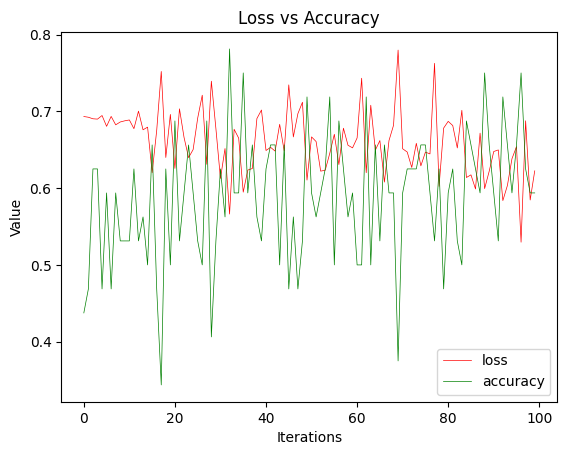

In [59]:
plt.plot(loss_history, color="red", label="loss", linewidth=0.5)
plt.plot(acc_history, color="green", label="accuracy", linewidth=0.5)

plt.xlabel("Iterations")
plt.ylabel("Value")

plt.title("Loss vs Accuracy")
plt.legend()
plt.show()